In [11]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [12]:
#processing pipeline

train_transform = transforms.Compose([
    #data augmentation to prevent overfitting
    transforms.RandomHorizontalFlip(), #flipping image (left <-> right ) with the default probability of 0.5
    transforms.RandomRotation(10), #rotate image upto 10 degrees

    #converting images into pytorch tensors in range [0,1]
    transforms.ToTensor(),
    #normalizing the tensor values leads to reduction in data skewness and neural networks learns faster
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    #converting images into pytorch tensors in range [0,1]
    transforms.ToTensor(),
    #normalizing the tensor values leads to reduction in data skewness and neural networks learns faster

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data  = datasets.CIFAR10('data', train = True, download= True, transform = train_transform)
test_data = datasets.CIFAR10('data', train = False, download= True, transform = test_transform)


In [13]:
print(train_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [14]:
#train and validation split
validation_size = len(train_data) * 0.2
validation_size = int(np.floor(validation_size))
#shuffle the training data indices and split
indices = list(range(len(train_data)))
np.random.shuffle(indices)

#so far we have training and testing data and shuffled indices of training data, now we need to split the indices
train_idx = indices[validation_size: ]
valid_idx = indices[: validation_size]

train = SubsetRandomSampler(train_idx)
valid = SubsetRandomSampler(valid_idx)

In [71]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 10, sampler = train)
val_loader = torch.utils.data.DataLoader(train_data, batch_size = 10, sampler = valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 20)


In [73]:
image, labels = next(iter(test_loader))
print(image[0].shape)
print(image.shape)

torch.Size([3, 32, 32])
torch.Size([20, 3, 32, 32])


Trying LeNet on color images!

In [17]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    # input_channels = 3 # rgb channels
    # output_channels = 6 # number of kernels
    # kernel_size = (5, 5) #size of kernel (height* width)
    #layer 1
    self.conv1 = nn.Conv2d(3, 6, 5) #default stride = 1, padding = 0
    #output dim = 28*28*6
    self.pool = nn.AvgPool2d(2, 2) # kernel_size = 2, stride = 2
    #outputdim = 14*14*6
    self.conv2 = nn.Conv2d(6, 16, 5)
    #output dim = 10*10*16
    # after avg pooling 5*5*16
    self.conv3 = nn.Conv2d(16, 120, 5)
    #after conv operation 5-5/1+1 = 1

    self.fn1 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = x.reshape(x.shape[0], -1) # x.shape[0] is batchsize and -1 gives 120*1*1
    x = F.relu(self.fn1(x))
    x = self.output(x)
    x = self.softmax(x)
    return x


In [18]:
model = Network()
print(model)
if torch.cuda.is_available():
  model.cuda()

Network(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fn1): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [19]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
#loss function
criterion = nn.CrossEntropyLoss()

epoch = 20
for i in range(1, epoch + 1):
  train_loss = 0.0
  val_loss = 0.0

  model.train()
  for data, labels  in train_loader:
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()
    optimizer.zero_grad()
    output = model(data) # forward pass
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * data.size(0)


  model.eval()
  with torch.inference_mode():
    for data, labels in val_loader:
      if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()
      output = model(data)
      loss = criterion(output, labels)
      val_loss += loss.item() * data.size(0)
  train_loss = train_loss / len(train_loader.dataset)
  val_loss = val_loss / len(val_loader.dataset)

  print(f"Epoch {i}: train loss: {train_loss}, validation loss: {val_loss}")


Epoch 1: train loss: 1.400113482260704, validation loss: 0.31694693900346754
Epoch 2: train loss: 1.2109144839406014, validation loss: 0.2819384606599808
Epoch 3: train loss: 1.1492860802292824, validation loss: 0.29189294538497923
Epoch 4: train loss: 1.1144177902698518, validation loss: 0.27724420999288557
Epoch 5: train loss: 1.0869773546159267, validation loss: 0.2842804557442665
Epoch 6: train loss: 1.06717208173275, validation loss: 0.26208552250266076
Epoch 7: train loss: 1.0523779689967632, validation loss: 0.27725985580682755
Epoch 8: train loss: 1.0478756324410439, validation loss: 0.26966663469672203
Epoch 9: train loss: 1.0277653447687627, validation loss: 0.26561214817762374
Epoch 10: train loss: 1.0226222335398196, validation loss: 0.26318085588514806
Epoch 11: train loss: 1.015117749083042, validation loss: 0.2705346855044365
Epoch 12: train loss: 1.0121985771894455, validation loss: 0.2617486073166132
Epoch 13: train loss: 1.0095429370313882, validation loss: 0.26465045

In [37]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

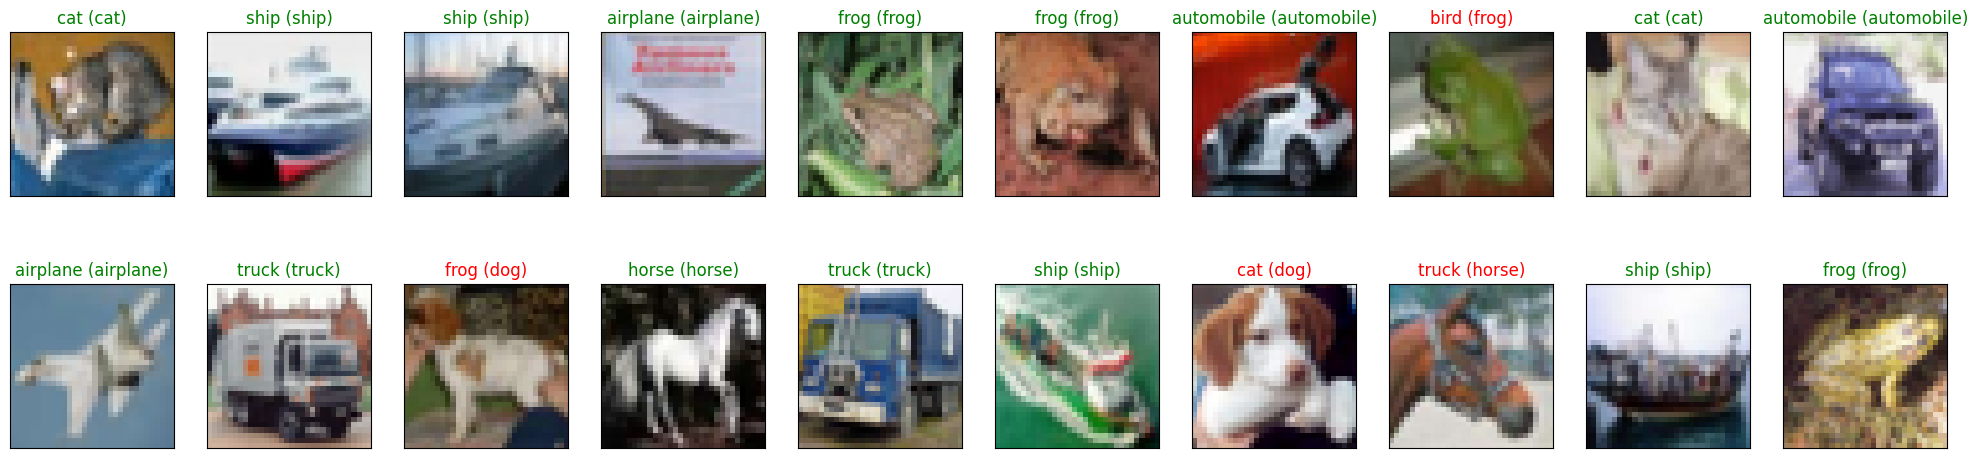

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 
    
img, labels = next(iter(test_loader))
img.numpy()
if torch.cuda.is_available():
    img, labels = img.cuda(), labels.cuda()
    

output = model(img)
_, class_pred = torch.max(output, 1)
output = class_pred.cpu().numpy()  


fig = plt.figure(figsize=(25, 6))
for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    imshow(img[i] if not torch.cuda.is_available() else img[i].cpu())
    ax.set_title("{} ({})".format(classes[output[i]], classes[labels[i]]),
                 color=("green" if output[i]==labels[i].item() else "red"))